# Extrem Value Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyextremes import EVA, __version__
from arch import arch_model
import arch


In [3]:
data = pd.read_excel("s&p 500.xlsx", index_col=0,parse_dates=True)
data.shape
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
data['Close'].index

DatetimeIndex(['2021-03-19', '2021-03-18', '2021-03-17', '2021-03-16',
               '2021-03-15', '2021-03-12', '2021-03-11', '2021-03-10',
               '2021-03-09', '2021-03-08',
               ...
               '1970-04-06', '1970-04-03', '1970-04-02', '1970-04-01',
               '1970-03-31', '1970-03-30', '1970-03-26', '1970-03-25',
               '1970-03-24', '1970-03-23'],
              dtype='datetime64[ns]', name='Date', length=12864, freq=None)

In [6]:
closed_price = [p.replace(',','') for p in data['Close']]
closed_price = np.array(closed_price)
closed_price = closed_price.astype(float)
daily_return = np.diff(closed_price) / closed_price[:-1]
log_daily_return = np.log(1 + daily_return)

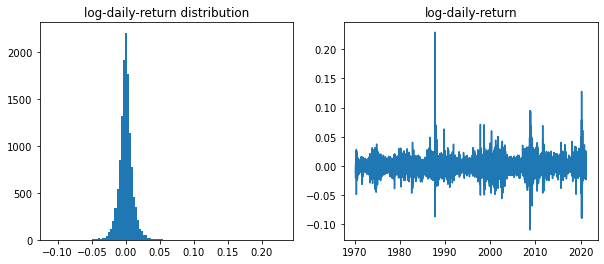

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (10,4))
ax1.set_title('log-daily-return distribution')
ax1.hist(log_daily_return, bins = int(np.sqrt(len(daily_return))))
ax2.set_title('log-daily-return')
ax2.plot(data['Close'][:-1].index,log_daily_return)

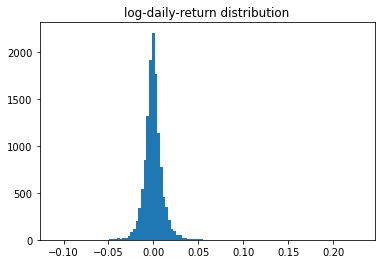

In [8]:
plt.title('log-daily-return distribution')
plt.hist(log_daily_return, bins = int(np.sqrt(len(daily_return))))
plt.savefig('log-daily-return distribution')


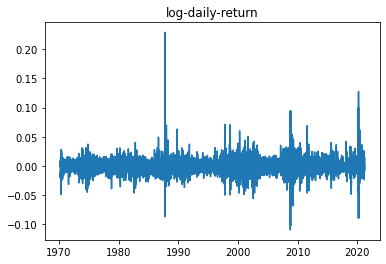

In [9]:
plt.title('log-daily-return')
plt.plot(data['Close'][:-1].index,log_daily_return)
plt.savefig('log daily return')
# plt.plot(data['Close'][:-1].index,closed_price[:-1])


In [10]:
returns = pd.Series(data = log_daily_return, index = data['Close'][:-1].index).sort_index(ascending=True)*100

In [11]:
am = arch_model(returns)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     37,   Neg. LLF: 16797.441080244724
Iteration:     10,   Func. Count:     66,   Neg. LLF: 16773.26353348577
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16773.26353348577
            Iterations: 11
            Function evaluations: 70
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -16773.3
Distribution:                  Normal   AIC:                           33554.5
Method:            Maximum Likelihood   BIC:                           33584.4
                                        No. Observations:                12863
Date:                Sat, Apr 09 2022   Df Residuals:                    12862
Time:         

<AxesSubplot:title={'center':'the variance fitted by GARCH'}, xlabel='Date'>

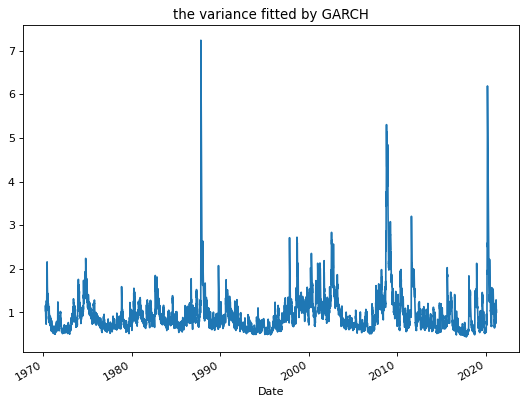

In [12]:
# ig = res.plot(annualize="D")
plt.figure(figsize=(8, 6), dpi=80)
plt.title('the variance fitted by GARCH')
res.conditional_volatility.plot()

In [13]:
forecasts = res.forecast(horizon=5,reindex=False)

## Block maxima

In [15]:
model_BM = EVA(data=pd.Series(data = log_daily_return, index = data['Close'][:-1].index).sort_index(ascending=True))
model_BM.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)
model_BM.fit_model()
model_BM

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                              12,863
Start:                         March 1970      End:                           March 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 51      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

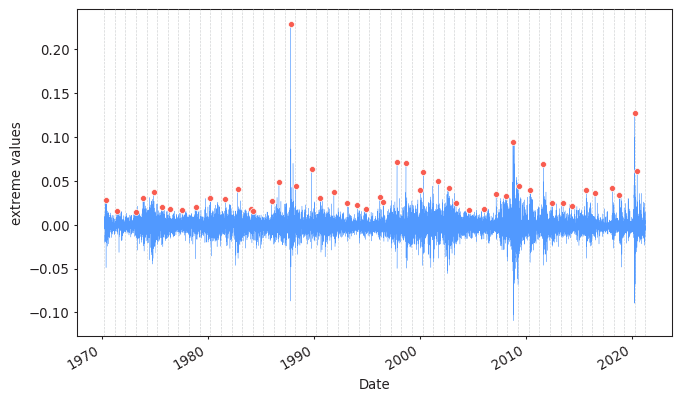

In [16]:
model_BM.plot_extremes()
plt.savefig('BM extraction of extrem value')

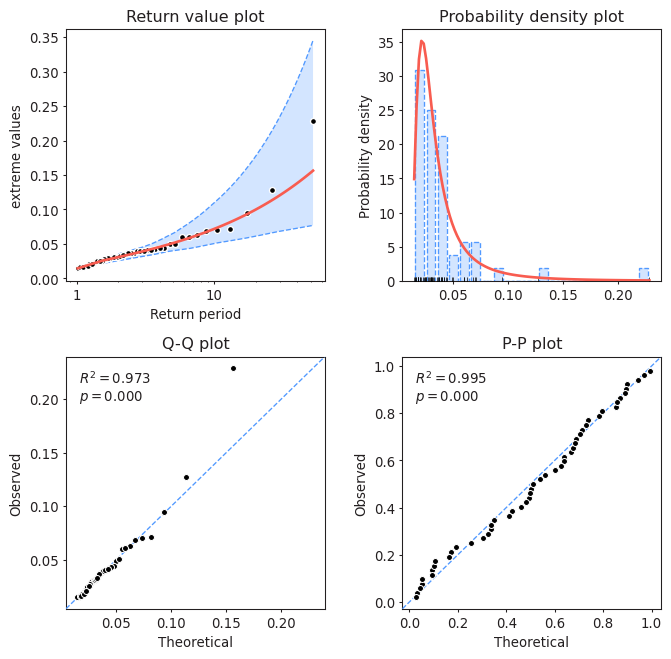

In [19]:
f, axes = model_BM.plot_diagnostic(alpha = 0.95)


## POT

In [21]:
data = pd.Series(data = log_daily_return, index = data['Close'][:-1].index).sort_index(ascending=True)


#  choose threshold

<AxesSubplot:xlabel='Threshold', ylabel='Mean excess'>

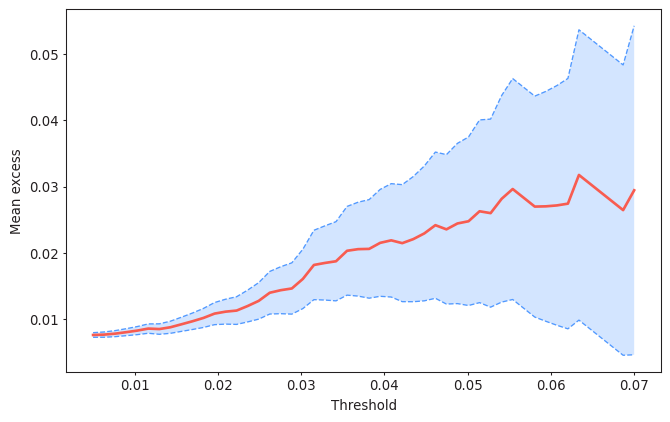

In [22]:
from pyextremes import plot_mean_residual_life

plot_mean_residual_life(data,thresholds=np.linspace(0.005,0.07))

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                              12,863
Start:                         March 1970      End:                           March 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 30      Extraction method:                    POT
Type:                                high      Threshold:                          0.023
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

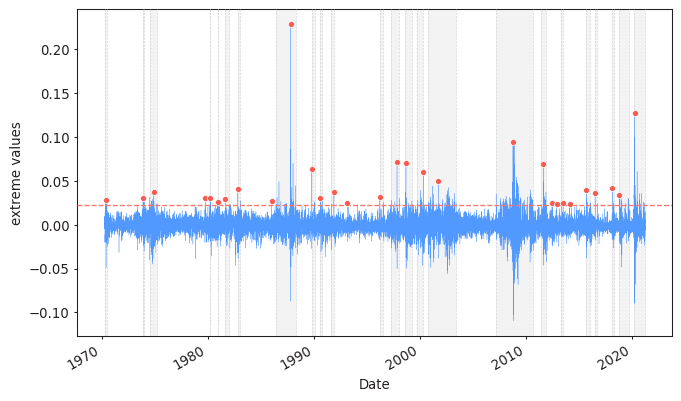

In [27]:
model = EVA(data = data)
model.get_extremes(
    method="POT",
    extremes_type="high",
    threshold = 0.023,
    r = '150D'
)
model.fit_model()
model.plot_extremes(show_clusters=True)
model

(<Figure size 768x768 with 4 Axes>,
 (<AxesSubplot:title={'center':'Return value plot'}, xlabel='Return period', ylabel='extreme values'>,
  <AxesSubplot:title={'center':'Probability density plot'}, ylabel='Probability density'>,
  <AxesSubplot:title={'center':'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <AxesSubplot:title={'center':'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

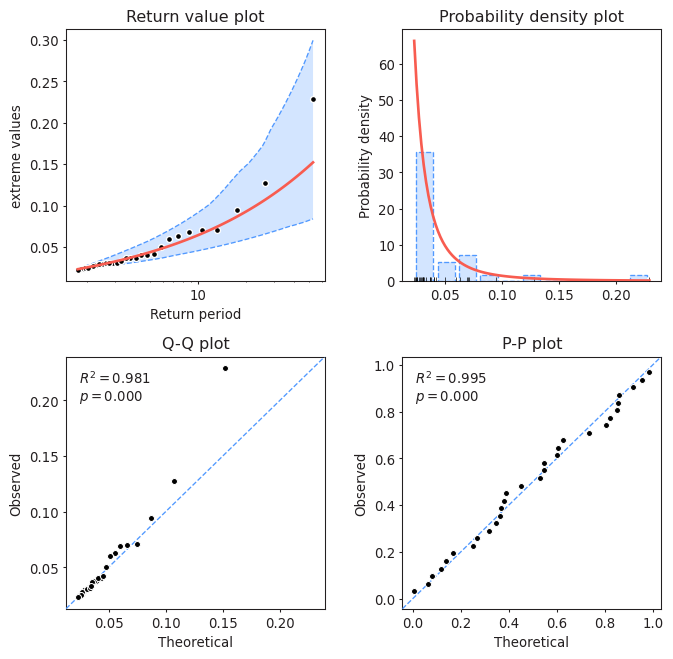

In [28]:
model.plot_diagnostic(alpha=0.95)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='Return period', ylabel='extreme values'>)

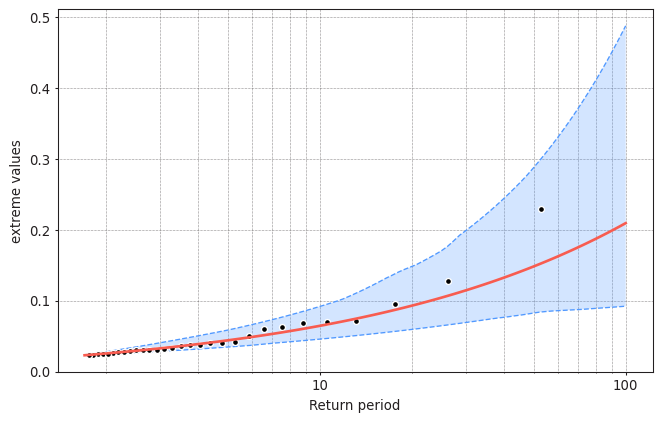

In [29]:
model.plot_return_values(
    return_period=np.logspace(0.01, 2, 100),
    alpha=0.95,
)

In [30]:
np.logspace(0.01, 2, 100)

array([  1.02329299,   1.07176855,   1.1225405 ,   1.17571763,
         1.23141387,   1.28974856,   1.35084668,   1.41483916,
         1.48186309,   1.55206209,   1.62558656,   1.70259405,
         1.78324954,   1.86772586,   1.95620399,   2.04887353,
         2.14593302,   2.24759042,   2.35406354,   2.46558053,
         2.58238031,   2.70471315,   2.83284115,   2.96703885,
         3.10759377,   3.25480708,   3.4089942 ,   3.57048549,
         3.73962697,   3.91678103,   4.10232726,   4.29666321,
         4.50020526,   4.71338954,   4.9366728 ,   5.17053347,
         5.41547261,   5.67201504,   5.94071043,   6.22213449,
         6.5168902 ,   6.82560912,   7.14895271,   7.48761377,
         7.84231792,   8.21382517,   8.6029315 ,   9.01047062,
         9.43731573,   9.8843814 ,  10.35262553,  10.84305137,
        11.35670972,  11.89470116,  12.45817839,  13.04834874,
        13.66647671,  14.31388672,  14.9919659 ,  15.70216714,
        16.44601212,  17.22509462,  18.0410839 ,  18.89